### Search Scope

In [2]:
import pandas as pd

# Load both datasets
paper_df = pd.read_csv('Paper_Dataset_Bio.csv')
project_df = pd.read_csv('Project_Dataset_Bio.csv')

# Calculate average Scope_Top_Count for each project
search_scope = paper_df.groupby('과제고유번호')['Scope_Top_Count'].mean().reset_index()
search_scope.rename(columns={'Scope_Top_Count': 'Search_Scope'}, inplace=True)

# Merge with the project dataset to add the Search_Scope
project_df = project_df.merge(search_scope, on='과제고유번호', how='left')

# Save the updated Project_Dataset_Bio.csv with the new 'Search_Scope' column
project_df.to_csv('Project_Dataset_Bio_with_Search_Scope.csv', index=False, encoding = 'utf-8-sig')

# Display the updated dataframe to verify
project_df.head()


,사업ID,부처명,총연구비,정부연구비,총연구기간_시작,총연구기간_종료,연구기간,참여인원_공동위탁,과학기술표준분류,육T관련기술,...,해외_출원_개수,해외_등록_개수,성과_개수,연도별_밀도,HHI,rv_HHI,GDC,num_external_tie,avg_num_external_tie,Search_Scope
0,1.81E+22,26,185190151,185190151,2014-01-01,2015-12-31,729,4,7,2,...,1,0,1,0.000624,1.000,0.000,0.000099,1,0.5,NaN
1,1.81E+22,26,194999756,194999756,2015-01-01,2017-12-31,1095,4,5,2,...,2,0,6,0.000551,0.500,0.500,0.000174,2,1.0,1.0
2,1.81E+22,26,290542826,290542826,2018-01-01,2019-12-31,729,3,5,2,...,2,0,10,0.000497,0.625,0.375,0.000334,4,2.0,1.6
3,1.81E+22,26,40000000,40000000,2018-01-01,2019-12-31,729,1,33,2,...,0,0,0,0.000497,1.000,0.000,0.000000,0,0.0,NaN
4,1.81E+22,26,280000000,210000000,2019-06-13,2020-12-31,567,4,14,2,...,0,0,1,0.000569,1.000,0.000,0.004284,49,24.5,NaN


In [6]:
import pandas as pd

# Load the datasets
paper_df = pd.read_csv('Paper_Dataset_Bio.csv')
project_df = pd.read_csv('Project_Dataset_Bio.csv')

# Step 1: Extract unique categories for each '과제고유번호' in paper_df
# Split 'Scope_Top' by ';', create a list of unique categories per '과제고유번호'
paper_df['Scope_Top'] = paper_df['Scope_Top'].str.split(';')

# Aggregate unique categories per '과제고유번호'
unique_scope_dict = (
    paper_df
    .explode('Scope_Top')  # This expands the categories in 'Scope_Top' column
    .drop_duplicates(['과제고유번호', 'Scope_Top'])  # Keep unique categories for each project
    .groupby('과제고유번호')['Scope_Top']
    .apply(lambda x: list(x.str.strip().unique()))  # Clean up whitespace, keep unique list
    .to_dict()
)

# Step 2: Add 'Unique_Scope' and 'Search_Scope_New' to project_df based on unique categories found
project_df['Unique_Scope'] = project_df['과제고유번호'].map(unique_scope_dict)
project_df['Search_Scope_New'] = project_df['Unique_Scope'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Save the updated Project_Dataset_Bio with new columns
project_df.to_csv('Project_Dataset_Bio_with_Scope.csv', index=False, encoding = 'utf-8-sig')

# Display result for verification
project_df[['과제고유번호', 'Unique_Scope', 'Search_Scope_New']].head()

,과제고유번호,Unique_Scope,Search_Scope_New
0,1315000776,NaN,0
1,1315000802,[Veterinary],1
2,1315001076,"[Biochemistry Genetics and Molecular Biology, ...",3
3,1315001122,NaN,0
4,1315001244,NaN,0


#### Network stability - Individual level

In [11]:
import pandas as pd
import re
from fuzzywuzzy import fuzz, process

# Load the paper dataset
paper_df = pd.read_csv('Paper_Dataset_Bio.csv')

# Function to standardize author names: lowercase, remove special characters, and remove spaces
def normalize_name(name):
    name = name.lower()
    name = re.sub(r'[^a-z]', '', name)  # Remove any non-alphabetic characters, including spaces
    return name

# Normalize each author name in the 'Authors' column by splitting and applying the normalize_name function
paper_df['Normalized_Authors'] = paper_df['Authors'].apply(lambda x: [normalize_name(author) for author in x.split('; ')])

# Using fuzzy matching to identify and standardize similar names across the dataset
def standardize_authors(author_list, similarity_threshold=90):
    unique_authors = set(author_list)
    author_map = {}

    # Compare each author to every other author in the set
    for author in unique_authors:
        if author not in author_map:
            # Find best match in the set based on threshold
            best_match = process.extractOne(author, unique_authors, scorer=fuzz.token_sort_ratio)
            if best_match and best_match[1] >= similarity_threshold:
                # Map similar authors to a single representative name
                author_map[author] = best_match[0]
            else:
                # If no close match, map the author to themselves
                author_map[author] = author

    # Return standardized list
    return [author_map[author] for author in author_list]

# Apply the standardization function to each row in Normalized_Authors
paper_df['Standardized_Authors'] = paper_df['Normalized_Authors'].apply(lambda authors: standardize_authors(authors))

# Drop intermediate columns and proceed with further analysis on 'Standardized_Authors'
paper_df.drop(columns=['Authors', 'Normalized_Authors'], inplace=True)
paper_df.rename(columns={'Standardized_Authors': 'Authors'}, inplace=True)

# Save the cleaned data or proceed with the next steps (e.g., network stability calculation)
paper_df.to_csv('Paper_Dataset_Bio_Cleaned.csv', index=False, encoding = 'utf-8-sig')

# Display a preview of the cleaned data to verify the changes
paper_df.head()


,ID,과제고유번호,과제수행년도,성과발생년도,성과발생부처명,성과사업ID,성과사업명,성과고유번호,논문_SCI구분_최종,Title,...,DOI,논문_기여율_확정,Affiliation,Affiliation_KR,Citation Count,Influential Citation Count,Abstract,육T관련기술,Scope_Top_Count,Authors
0,39,1315000802,2016,2016,26,1.81E+22,중장기과학수사감정기법연구개발,18111002002324002434300-2016-2016-유전자-01-TSS-2...,1.0,Population genetic study of 10 short tandem re...,...,NaN,50.0,Graduate School of Convergence Science and Tec...,국립과학수사연구원; 서울대학,6,1,Dogs have long shared close relationships with...,2,1,"[smoon, yoonjeongjang, mhan, mcho]"
1,72,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,Enhanced sensitivity of CpG island search and ...,...,10.1016/j.fsigen.2018.02.013,50.0,National Forensic Service; Seoul National Univ...,국립과학수사연구원; 서울대학,2,0,NaN,2,2,"[hyunchulpark, eureeahn, jjung, jihyepark, jee..."
2,73,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,Rapid oral bacteria detection based on real-ti...,...,10.1038/s41598-018-29264-2,100.0,National Forensic Service; Kyungbok University,국립과학수사연구원; 경복대학,49,0,NaN,2,1,"[jjung, hyoon, sanghyunan, jeewonlee, eureeahn..."
3,74,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,A validation study of DNA methylation-based ag...,...,10.1016/j.legalmed.2018.01.005,100.0,National Forensic Service; Yonsei University C...,국립과학수사연구원; 연세대학,27,3,NaN,2,1,"[jeewonlee, cchoung, jjung, hwanyounglee, sike..."
4,75,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,A Simple Method of VNTR D1S80 Locus Allelic La...,...,10.1111/1556-4029.13587,100.0,National Forensic Service,국립과학수사연구원,3,0,VNTR D1S80 locus genotyping has been largely r...,2,2,"[jjung, sujikim, yulioh, sikeunlim, yanghanlee..."


In [ ]:
import pandas as pd
from itertools import combinations

# Load data from CSV files
paper_data = pd.read_csv("Paper_Dataset_Bio.csv")
project_data = pd.read_csv("Project_Dataset_Bio.csv")

# Function to calculate pairwise stability between two papers
def calculate_pairwise_stability(authors_list1, authors_list2):
    set1 = set(authors_list1)
    set2 = set(authors_list2)
    common_authors = set1.intersection(set2)
    total_unique_authors = set1.union(set2)
    
    if len(total_unique_authors) == 0:
        return 0
    else:
        return len(common_authors) / len(total_unique_authors)

# Function to calculate overall network stability for each project
def calculate_overall_network_stability(grouped_papers):
    num_papers = len(grouped_papers)
    if num_papers < 2:
        return None  # Skip calculation if fewer than two papers
    
    # Calculate pairwise stability for each unique pair of papers in the project
    pairwise_stability_sum = 0
    pair_count = 0
    
    for paper1, paper2 in combinations(grouped_papers, 2):
        pairwise_stability_sum += calculate_pairwise_stability(paper1, paper2)
        pair_count += 1
    
    # Calculate the overall network stability
    overall_stability = (2 / (num_papers * (num_papers - 1))) * pairwise_stability_sum
    return overall_stability

# Prepare the 'Authors_Nom' field by converting strings to lists
paper_data['Authors_Nom'] = paper_data['Authors_Nom'].apply(eval)

# Group by '과제고유번호' and calculate stability for each project
project_stability = paper_data.groupby('과제고유번호')['Authors_Nom'].apply(list).apply(calculate_overall_network_stability)

# Add the calculated network stability to the project dataset
project_data = project_data.merge(project_stability.rename('Network_Stability'), on='과제고유번호', how='left')

# Save the updated project dataset
project_data.to_csv("Project_Dataset_Bio_with_Network_Stability.csv", index=False, encoding= 'utf-8-sig')

Network Stability calculation complete and saved to Project_Dataset_Bio.csv


#### Network Stability - Organizational Level

In [2]:
import pandas as pd
import re
from fuzzywuzzy import fuzz, process

# Load the paper dataset
paper_df = pd.read_csv('Paper_Dataset_Bio.csv')

# Function to standardize affiliation names: lowercase, remove special characters, and remove spaces
def normalize_affiliation(affiliation):
    # Convert to lowercase
    affiliation = affiliation.lower()
    # Remove any non-Korean or non-alphabet characters, including spaces
    affiliation = re.sub(r'[^가-힣a-z]', '', affiliation)
    return affiliation

# Normalize each organization name in the 'Affiliation_KR' column
paper_df['Normalized_Affiliation'] = paper_df['Affiliation_KR'].apply(
    lambda x: [normalize_affiliation(org) for org in x.split('; ')]
)

# Using fuzzy matching to identify and standardize similar affiliation names across the dataset
def standardize_affiliations(affiliation_list, similarity_threshold=90):
    unique_affiliations = set(affiliation_list)
    affiliation_map = {}

    # Compare each organization to every other organization in the set
    for affiliation in unique_affiliations:
        if affiliation not in affiliation_map:
            # Find best match in the set based on the threshold
            best_match = process.extractOne(affiliation, unique_affiliations, scorer=fuzz.token_sort_ratio)
            if best_match and best_match[1] >= similarity_threshold:
                # Map similar affiliations to a single representative name
                affiliation_map[affiliation] = best_match[0]
            else:
                # If no close match, map the affiliation to itself
                affiliation_map[affiliation] = affiliation

    # Return standardized list
    return [affiliation_map[affiliation] for affiliation in affiliation_list]

# Apply the standardization function to each row in Normalized_Affiliation
paper_df['Standardized_Affiliation'] = paper_df['Normalized_Affiliation'].apply(
    lambda orgs: standardize_affiliations(orgs)
)

# Drop intermediate columns and keep only the standardized 'Affiliation' column for further analysis
paper_df.drop(columns=['Affiliation_KR', 'Normalized_Affiliation'], inplace=True)
paper_df.rename(columns={'Standardized_Affiliation': 'Affiliation'}, inplace=True)

# Save the cleaned data to a new file for network stability calculation
paper_df.to_csv('Paper_Dataset_Bio_Cleaned.csv', index=False, encoding='utf-8-sig')

# Display a preview of the cleaned data to verify the changes
paper_df.head()

,ID,과제고유번호,과제수행년도,성과발생년도,성과발생부처명,성과사업ID,성과사업명,성과고유번호,논문_SCI구분_최종,Title,...,논문_기여율_확정,Affiliation,Authors,Authors_Nom,Citation Count,Influential Citation Count,Abstract,육T관련기술,Scope_Top_Count,Affiliation
0,39,1315000802,2016,2016,26,1.81E+22,중장기과학수사감정기법연구개발,18111002002324002434300-2016-2016-유전자-01-TSS-2...,1.0,Population genetic study of 10 short tandem re...,...,50.0,Graduate School of Convergence Science and Tec...,S. Moon; Yoonjeong Jang; M. Han; M. Cho,"['smoon', 'yoonjeongjang', 'mhan', 'mcho']",6,1,Dogs have long shared close relationships with...,2,1,"[국립과학수사연구원, 서울대학]"
1,72,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,Enhanced sensitivity of CpG island search and ...,...,50.0,National Forensic Service; Seoul National Univ...,Hyun-Chul Park; Eu-Ree Ahn; J. Jung; Jihye Par...,"['hyunchulpark', 'eureeahn', 'jjung', 'jihyepa...",2,0,NaN,2,2,"[국립과학수사연구원, 서울대학]"
2,73,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,Rapid oral bacteria detection based on real-ti...,...,100.0,National Forensic Service; Kyungbok University,J. Jung; H. Yoon; Sanghyun An; Jee Won Lee; Eu...,"['jjung', 'hyoon', 'sanghyunan', 'jeewonlee', ...",49,0,NaN,2,1,"[국립과학수사연구원, 경복대학]"
3,74,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,A validation study of DNA methylation-based ag...,...,100.0,National Forensic Service; Yonsei University C...,Jee Won Lee; C. Choung; J. Jung; Hwan Young Le...,"['jeewonlee', 'cchoung', 'jjung', 'hwanyoungle...",27,3,NaN,2,1,"[국립과학수사연구원, 연세대학]"
4,75,1315001076,2018,2018,26,1.81E+22,중장기과학수사감정기법연구개발(R&D),NaN,1.0,A Simple Method of VNTR D1S80 Locus Allelic La...,...,100.0,National Forensic Service,J. Jung; Su-ji Kim; Yu-Li Oh; Si-Keun Lim; Yan...,"['jjung', 'sujikim', 'yulioh', 'sikeunlim', 'y...",3,0,VNTR D1S80 locus genotyping has been largely r...,2,2,[국립과학수사연구원]


In [3]:
import pandas as pd
from itertools import combinations

# Load data from CSV files
paper_data = pd.read_csv("Paper_Dataset_Bio.csv")
project_data = pd.read_csv("Project_Dataset_Bio.csv")

# Function to calculate pairwise stability between two lists of affiliations
def calculate_pairwise_stability(affiliation_list1, affiliation_list2):
    set1 = set(affiliation_list1)
    set2 = set(affiliation_list2)
    common_affiliations = set1.intersection(set2)
    total_unique_affiliations = set1.union(set2)
    
    if len(total_unique_affiliations) == 0:
        return 0
    else:
        return len(common_affiliations) / len(total_unique_affiliations)

# Function to calculate overall network stability for each project based on affiliations
def calculate_overall_network_stability(grouped_papers):
    num_papers = len(grouped_papers)
    if num_papers < 2:
        return None  # Skip calculation if fewer than two papers
    
    # Calculate pairwise stability for each unique pair of papers in the project
    pairwise_stability_sum = 0
    pair_count = 0
    
    for paper1, paper2 in combinations(grouped_papers, 2):
        pairwise_stability_sum += calculate_pairwise_stability(paper1, paper2)
        pair_count += 1
    
    # Calculate the overall network stability
    overall_stability = (2 / (num_papers * (num_papers - 1))) * pairwise_stability_sum
    return overall_stability

# Prepare the 'Affiliation' field by converting strings to lists
paper_data['Affiliation'] = paper_data['Affiliation'].apply(eval)

# Group by '과제고유번호' and calculate stability for each project based on affiliations
project_stability = paper_data.groupby('과제고유번호')['Affiliation'].apply(list).apply(calculate_overall_network_stability)

# Add the calculated network stability to the project dataset
project_data = project_data.merge(project_stability.rename('Net_Stability_Org'), on='과제고유번호', how='left')

# Save the updated project dataset
project_data.to_csv("Project_Dataset_Bio_with_Network_Stability.csv", index=False, encoding='utf-8-sig')


#### Network Inconsistency (Organizational Level)

In [4]:
import pandas as pd

# Load the datasets
paper_data = pd.read_csv("Paper_Dataset_Bio.csv")
project_data = pd.read_csv("Project_Dataset_Bio.csv")

# Split affiliations into lists and remove duplicates within each project
paper_data['Affiliation'] = paper_data['Affiliation'].apply(lambda x: x.split(', '))

# Aggregate unique affiliations for each '과제고유번호'
unique_affiliations = paper_data.groupby('과제고유번호')['Affiliation'].apply(lambda x: set([aff for sublist in x for aff in sublist]))

# Convert the set back to a comma-separated string
unique_affiliations = unique_affiliations.apply(lambda x: ', '.join(x))

# Merge unique affiliations into project_data
project_data = project_data.merge(unique_affiliations.rename('unique_org'), on='과제고유번호', how='left')

# Save the updated project data to CSV
project_data.to_csv("Project_Dataset_Bio_with_Unique_Org.csv", index=False, encoding='utf-8-sig')

# Display a preview to verify changes
project_data.head()


,사업ID,부처명,총연구비,정부연구비,총연구기간_시작,총연구기간_종료,연구기간,참여인원_공동위탁,과학기술표준분류,육T관련기술,...,rv_HHI,GDC,num_external_tie,avg_num_external_tie,Search_Scope,Search_Scope_Nom,Search_Scope_Avg,Net_Stability_Ind,Net_Stability_Org,unique_org
0,1.81E+22,26,185190151,185190151,2014-01-01,2015-12-31,729,4,7,2,...,0.000,0.000099,1,0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,1.81E+22,26,194999756,194999756,2015-01-01,2017-12-31,1095,4,5,2,...,0.500,0.000174,2,1.0,1.0,0.058824,1.0,NaN,NaN,"국립과학수사연구원, 서울대학"
2,1.81E+22,26,290542826,290542826,2018-01-01,2019-12-31,729,3,5,2,...,0.375,0.000334,4,2.0,3.0,0.176471,1.6,0.32491,0.5,"경복대학, 국립과학수사연구원, 연세대학, 서울대학"
3,1.81E+22,26,40000000,40000000,2018-01-01,2019-12-31,729,1,33,2,...,0.000,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.81E+22,26,280000000,210000000,2019-06-13,2020-12-31,567,4,14,2,...,0.000,0.004284,49,24.5,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd

# Load the project data
project_data = pd.read_csv("Project_Dataset_Bio_with_Unique_Org.csv")

# Function to check if formal organization is a substring of any combined organization
def are_orgs_equal(formal_org, combined_org):
    # Check if formal_org is a substring of combined_org or vice versa
    return formal_org in combined_org or combined_org in formal_org

# Function to calculate network inconsistency
def calculate_inconsistency(formal_orgs, combined_orgs):
    formal_set = set(formal_orgs.split(', '))  # Formal organizations (협업_매트릭스)
    combined_set = set(combined_orgs.split(', '))  # Combined organizations (unique_org)

    unmatched_count = 0

    # Check each combined organization if it matches any formal organization
    for combined in combined_set:
        match_found = False
        for formal in formal_set:
            # If the organization is a substring of another, treat it as a match
            if are_orgs_equal(formal, combined):
                match_found = True
                break
        if not match_found:
            unmatched_count += 1

    # Calculate inconsistency as the proportion of unmatched organizations in 'unique_org'
    inconsistency = unmatched_count / len(combined_set) if combined_set else 0
    return inconsistency

# Apply the inconsistency calculation to the dataframe
project_data['Net_Incon'] = project_data.apply(
    lambda row: calculate_inconsistency(row['협업_매트릭스'], row['unique_org']) 
    if isinstance(row['unique_org'], str) and row['unique_org'] else None, axis=1
)

# Save the updated project data to a new CSV file
project_data.to_csv("Project_Dataset_Bio_with_Net_Incon.csv", index=False, encoding='utf-8-sig')

# Display a preview to verify changes
project_data.head()


,과제고유번호,과제수행년도,협업_매트릭스,unique_org,Net_Incon
0,1315000776,2015,"국립과학수사연구원, 인터페이스정보기술",NaN,NaN
1,1315000802,2016,"국립과학수사연구원, 리마커블소프트","국립과학수사연구원, 서울대학",0.50
2,1315001076,2018,"국립과학수사연구원, 인터페이스정보기술","경복대학, 국립과학수사연구원, 연세대학, 서울대학",0.75
3,1315001122,2018,"한국평가원, 한국평가원",NaN,NaN
4,1315001244,2019,"아라레연구소, 강원대학",NaN,NaN


#### Network Inconsistency - Informal 중복 허용

In [13]:
import pandas as pd

# Load the datasets
paper_data = pd.read_csv("Paper_Dataset_Bio.csv")
project_data = pd.read_csv("Project_Dataset_Bio.csv")

# Split affiliations into lists and preserve all occurrences (don't remove duplicates)
paper_data['Affiliation'] = paper_data['Affiliation'].apply(lambda x: x.split(', '))

# Aggregate all affiliations for each '과제고유번호' (including duplicates)
redundant_affiliations = paper_data.groupby('과제고유번호')['Affiliation'].apply(lambda x: [aff for sublist in x for aff in sublist])

# Convert the list back to a comma-separated string (including duplicates)
redundant_affiliations = redundant_affiliations.apply(lambda x: ', '.join(x))

# Merge redundant affiliations into project_data
project_data = project_data.merge(redundant_affiliations.rename('org_redundant'), on='과제고유번호', how='left')

# Save the updated project data to CSV
project_data.to_csv("Project_Dataset_Bio_with_Redundant_Org.csv", index=False, encoding='utf-8-sig')

# Display a preview to verify changes
project_data.head()


,사업ID,부처명,총연구비,정부연구비,총연구기간_시작,총연구기간_종료,연구기간,참여인원_공동위탁,과학기술표준분류,육T관련기술,...,GDC,num_external_tie,avg_num_external_tie,Search_Scope,Search_Scope_Nom,Search_Scope_Avg,Net_Stability_Ind,Net_Stability_Org,Net_Incon,org_redundant
0,1.81E+22,26,185190151,185190151,2014-01-01,2015-12-31,729,4,7,2,...,0.000099,1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.81E+22,26,194999756,194999756,2015-01-01,2017-12-31,1095,4,5,2,...,0.000174,2,1.0,1.0,0.058824,1.0,NaN,NaN,0.50,"국립과학수사연구원, 서울대학"
2,1.81E+22,26,290542826,290542826,2018-01-01,2019-12-31,729,3,5,2,...,0.000334,4,2.0,3.0,0.176471,1.6,0.32491,0.5,0.75,"국립과학수사연구원, 서울대학, 국립과학수사연구원, 경복대학, 국립과학수사연구원, 연..."
3,1.81E+22,26,40000000,40000000,2018-01-01,2019-12-31,729,1,33,2,...,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.81E+22,26,280000000,210000000,2019-06-13,2020-12-31,567,4,14,2,...,0.004284,49,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
import pandas as pd

# Load the project data
project_data = pd.read_csv("Project_Dataset_Bio_with_Redundant_Org.csv")

# Function to check if formal organization is a substring of any combined organization
def are_orgs_equal(formal_org, combined_org):
    # Check if formal_org is a substring of combined_org or vice versa
    return formal_org in combined_org or combined_org in formal_org

# Function to calculate network inconsistency
def calculate_inconsistency(formal_orgs, combined_orgs):
    formal_set = formal_orgs.split(', ')  # Formal organizations (협업_매트릭스) (no conversion to set, keep duplicates)
    combined_list = combined_orgs.split(', ')  # Combined organizations (org_redundant) (list with duplicates)

    unmatched_count = 0

    # Check each combined organization if it matches any formal organization
    for combined in combined_list:
        match_found = False
        for formal in formal_set:
            # If the organization is a substring of another, treat it as a match
            if are_orgs_equal(formal, combined):
                match_found = True
                break
        if not match_found:
            unmatched_count += 1

    # Calculate inconsistency as the proportion of unmatched organizations in 'org_redundant'
    inconsistency = unmatched_count / len(combined_list) if len(combined_list) else 0
    return inconsistency

# Apply the inconsistency calculation to the dataframe
project_data['Net_Incon'] = project_data.apply(
    lambda row: calculate_inconsistency(row['협업_매트릭스'], row['org_redundant']) 
    if isinstance(row['org_redundant'], str) and row['org_redundant'] else None, axis=1
)

# Save the updated project data to a new CSV file
project_data.to_csv("Project_Dataset_Bio_with_Net_Incon_2.csv", index=False, encoding='utf-8-sig')

# Display a preview to verify changes
project_data.head()


,과제수행년도,협업_매트릭스,org_redundant,Net_Incon
0,2015,"국립과학수사연구원, 인터페이스정보기술",NaN,NaN
1,2016,"국립과학수사연구원, 리마커블소프트","국립과학수사연구원, 서울대학",0.500
2,2018,"국립과학수사연구원, 인터페이스정보기술","국립과학수사연구원, 서울대학, 국립과학수사연구원, 경복대학, 국립과학수사연구원, 연...",0.375
3,2018,"한국평가원, 한국평가원",NaN,NaN
4,2019,"아라레연구소, 강원대학",NaN,NaN


#### 사업 ID -> Re-mapping

In [8]:
import pandas as pd

# Step 1: Load the datasets
business_info = pd.read_stata("1.Business_info_230130.dta", convert_categoricals=False)
project_data = pd.read_csv("Project_Dataset_Bio.csv")

# Step 2: Merge `ac010` from `1.Business_info_230130.dta` into `Project_Dataset_Bio` using `ad010` as the unique identifier
# Perform a left merge based on `ad010` (과제고유번호 in 1.Business_info_230130.dta)
merged_data = project_data.merge(business_info[['ad010', 'ac010']], left_on='과제고유번호', right_on='ad010', how='left')
merged_data = merged_data.rename(columns={'ac010': '사업ID_original'})

# Drop the extra `ad010` column after merging
merged_data = merged_data.drop(columns=['ad010'])

# Step 3: Generate sequential numeric IDs for each unique `사업ID_original`
# Create a new column `사업ID_re` with unique numbers for each `사업ID_original`
merged_data['사업ID_re'] = merged_data['사업ID_original'].astype('category').cat.codes + 1

# Step 4: Save the updated dataset
merged_data.to_csv("Project_Dataset_Bio_updated.csv", index=False, encoding='utf-8-sig')

print("Data processing complete. Updated file saved as 'Project_Dataset_Bio_updated.csv'.")


Data processing complete. Updated file saved as 'Project_Dataset_Bio_updated.csv'.


In [10]:
import pandas as pd

# Step 1: Load the datasets
iur_project = pd.read_csv("IUR_project_240513.csv")
project_dataset_bio = pd.read_csv("Project_Dataset_Bio.csv")

# Step 2: Select the columns to merge from `IUR_project_240513.csv`
# We're interested in '과제고유번호', 'Avg_Blau_Partner', '공동위탁여부', 'Project_Phase', 'Density_Ind', 'Density_Sci', 'Density_Ego'
columns_to_merge = ['과제고유번호', 'Avg_Blau_Partner', '공동위탁여부', 'Project_Phase', 'Density_Ind', 'Density_Sci', 'Density_Ego']
iur_project = iur_project[columns_to_merge]

# Step 3: Merge based on `과제고유번호`
merged_data = project_dataset_bio.merge(iur_project, on='과제고유번호', how='left')

# Step 4: Save the updated dataset
merged_data.to_csv("Project_Dataset_Bio_updated.csv", index=False, encoding='utf-8-sig')

print("Data processing complete. Updated file saved as 'Project_Dataset_Bio_updated.csv'.")


Data processing complete. Updated file saved as 'Project_Dataset_Bio_updated.csv'.


In [ ]:
import pandas as pd

# CSV 파일을 pandas DataFrame으로 읽어옵니다.
csv_file = "Project_Dataset_Bio.csv"
df = pd.read_csv(csv_file, encoding='utf-8')

column_mapping = {
    '사업ID': 'orgID',
    '사업ID_re': 'ID',
    '부처명': 'Department_Name',
    '공동위탁여부' : 'Joint_or_Contract',
    '총연구비': 'Total_Research_Funding',
    '정부연구비': 'Gov_Research_Funding',
    '총연구기간_시작': 'Research_Period_Start',
    '총연구기간_종료': 'Research_Period_End',
    '연구기간': 'Research_Period',
    '참여인원_공동위탁': 'Num_Researchers',
    '과학기술표준분류': 'Industry_Science_Tech',
    '육T관련기술': 'Industry_6T',
    '연구개발단계': 'Research_Development_Stage',
    '경제사회목적': 'Economic_Social_Purpose',
    '과제고유번호': 'Project_ID',
    '과제수행년도': 'Project_Year',
    '협업_매트릭스': 'Collaboration_Matrix',
    '협업_type_new': 'Collaboration_Matrix_Type',
    '총_참여조직_수': 'Num_Organizations',
    '대기업_수': 'Num_Large_Firm',
    '중견_수': 'Num_Medium_Firm',
    '중소_수': 'Num_Small_Firm',
    '대학_수': 'Num_Univ',
    '연구기관_수': 'Num_RI',
    '기타_수': 'Num_Others',
    'blau_index': 'Blau_Index',
    '논문_개수': 'Num_Papers',
    'SCI_개수': 'Num_SCI_Papers',
    '비SCI개수': 'Num_Non_SCI_Papers',
    '특허_개수': 'Num_Patents',
    '출원_개수': 'Num_Applications',
    '등록_개수': 'Num_Registrations',
    '국내_특허_개수': 'Num_Domestic_Patents',
    '국내_출원_개수': 'Num_Domestic_Applications',
    '국내_등록_개수': 'Num_Domestic_Registrations',
    '해외_특허_개수': 'Num_Foreign_Patents',
    '해외_출원_개수': 'Num_Foreign_Applications',
    '해외_등록_개수': 'Num_Foreign_Registrations',
    '성과_개수': 'Num_Perf',
    '연도별_밀도': 'Density_by_Year',
    'HHI': 'HHI',
    'rv_HHI': 'HHI_Reverse',
    'GDC': 'GDC',
    'num_external_tie': 'Num_External_Ties',
    'avg_num_external_tie': 'Avg_Num_External_Ties',
    'Avg_Blau_Partner': 'Avg_Blau_Partner',
    '공동위탁여부': 'Joint_or_Contract',
    'Project_Phase': 'Project_Phase'
}

# 열 이름을 변경하고, 결과를 새로운 DataFrame에 저장
df.rename(columns=column_mapping, inplace=True)

# 3. DTA 파일로 내보내기
dta_file_path = 'Project_Dataset_Bio.dta'
df = df.apply(lambda x: x.astype(str).str.encode('ascii', 'ignore').str.decode('ascii', 'ignore'))
df.to_stata(dta_file_path, version=118)

ValueError: Column `Search_Scope` cannot be exported.

Only string-like object arrays
containing all strings or a mix of strings and None can be exported.
Object arrays containing only null values are prohibited. Other object
types cannot be exported and must first be converted to one of the
supported types.

#### 추가 Control variable

In [2]:
import pandas as pd

dta_path = "Project_Dataset_Bio.dta"
dta_raw = pd.read_stata(dta_path, convert_categoricals=False, convert_missing=False, iterator=True)
project_dataset = dta_raw.read()
pd.options.display.float_format = '{:.0f}'.format

csv_file = "Paper_Dataset_Bio.csv"
paper_dataset = pd.read_csv(csv_file, encoding='utf-8-sig')


In [ ]:
# import pandas as pd

# csv_file2 = "dict_kor.csv"
# dict_kor = pd.read_csv(csv_file2, encoding='utf-8-sig')

# # 매핑 딕셔너리 생성 ('Organization_KOR' -> 'Organization_Net')
# mapping_dict = dict(zip(dict_kor['Organization_KOR'], dict_kor['Organization_Net']))

# # Affiliation_KR 열 업데이트 함수
# def update_affiliation(affiliations, mapping):
#     # 조직명을 분리 (세미콜론 ';' 기준)
#     orgs = [org.strip() for org in affiliations.split(';')]
#     # 매핑된 이름으로 변환, 매핑이 없으면 원래 이름 유지
#     updated_orgs = [mapping.get(org, org) for org in orgs]
#     # 다시 세미콜론으로 결합
#     return '; '.join(updated_orgs)

# # 'Affiliation_KR' 열을 매핑에 따라 업데이트하여 새로운 열 'Affiliation_Net' 생성
# paper_dataset['Affiliation_Net'] = paper_dataset['Affiliation_KR'].apply(lambda x: update_affiliation(x, mapping_dict))

# # 결과 확인
# print(paper_dataset[['Affiliation_KR', 'Affiliation_Net']])

# # 결과를 CSV 파일로 저장 (필요시 사용)
# output_file = "Updated_Paper_Dataset_Bio.csv"
# paper_dataset.to_csv(output_file, index=False, encoding='utf-8-sig')


In [3]:
def get_external_link_list(same_year_paper):
    # external_link_list[year][기관명] = 그 해의 그 기관이 한 번이라도 협업한 모든 기관의 목록 (set)
    external_link_list = dict()

    print(same_year_paper.size())

    for year, paper_per_year in same_year_paper:
        if year == 2021: 
            continue
        external_link_list[year] = dict()
        
        # 모든 논문의 기관 정보를 모으되, 중복된 기관명은 제거
        all_affiliations = paper_per_year['Affiliation_Net'].apply(
            lambda x: set([entry.strip() for entry in x.split(';')])
        )
        
        # 각 기관별 외부 협력 목록 계산
        for institution in set.union(*all_affiliations):
            # 자신이 포함된 논문들에서 다른 기관만 추출
            external_link = set.union(*all_affiliations[all_affiliations.apply(lambda x: institution in x)]) - {institution}
            
            # 외부 협력 목록 저장
            external_link_list[year][institution] = external_link

    return external_link_list

same_year_paper = paper_dataset.groupby('과제수행년도')
external_link_list = get_external_link_list(same_year_paper)


과제수행년도
2012    777
2013    495
2014    549
2015    697
2016    635
2017    910
2018    948
2019    752
2020    737
dtype: int64


In [9]:
# GDC
institutions = dict()
for year, paper_per_year in same_year_paper: 
    institutions[year] = set([entry.strip() for entry in ';'.join(paper_per_year['Affiliation_Net']).split(';')])

def calculate_group_dcen(row):
    year = row['과제수행년도']
    participants = set([entry.strip() for entry in row['Affiliation_Net'].split(';')]) # focal project
    
    external_vertex = set()

    for participant in participants:
        
        # Check other projects the participant is involved in
        external_ver = external_link_list[year][participant] - participants
        external_vertex.update(external_ver)
  
    GDC = len(external_vertex) / len(institutions[year] - participants)
    
    return GDC

def calculate_num_external_tie(row):
    year = row['과제수행년도']
    participants = set([entry.strip() for entry in row['Affiliation_Net'].split(';')]) # focal project
    
    external_vertex = set()

    for participant in participants:
        
        # Check other projects the participant is involved in
        external_ver = external_link_list[year][participant] - participants
        external_vertex.update(external_ver)

    # Calculate avg_num_external_tie by dividing len(external_vertex) by the total number of participants
    num_external_tie = len(external_vertex)
    
    return num_external_tie

# 'GDC'와 'avg_num_external_tie' 열을 계산하여 결과에 추가
paper_dataset['GDC_Paper'] = paper_dataset.apply(calculate_group_dcen, axis=1)
paper_dataset['num_external_tie_paper'] = paper_dataset.apply(calculate_num_external_tie, axis=1)

In [10]:
def calculate_avg_num_external_tie(row):
    year = row['과제수행년도']
    participants = set([entry.strip() for entry in row['Affiliation_Net'].split(';')]) # focal project
    
    external_vertex = set()

    for participant in participants:
        # Check other projects the participant is involved in
        external_ver = external_link_list[year][participant] - participants
        external_vertex.update(external_ver)
  
    # Calculate the average number of external ties for each actor in the project
    num_actors = len(participants)
    if num_actors == 0:
        return 0  # Avoid division by zero
    avg_num_external_tie = len(external_vertex) / num_actors
    
    return avg_num_external_tie

# Calculate average number of external ties for each project
paper_dataset['avg_num_external_tie_paper'] = paper_dataset.apply(calculate_avg_num_external_tie, axis=1)

In [11]:
output_file = "Updated_Paper_Dataset_Bio.csv"
paper_dataset.to_csv(output_file, index=False, encoding='utf-8-sig')

In [7]:
def get_top_organizations_by_degree_centrality(same_year_paper):
    # Store degree centrality per year
    degree_centrality = dict()

    for year, paper_per_year in same_year_paper:
        if year == 2021: 
            continue
        
        # Collect all affiliations in each paper and remove duplicates
        all_affiliations = paper_per_year['Affiliation_Net'].apply(
            lambda x: set([entry.strip() for entry in x.split(';')])
        )
        
        # Calculate degree centrality for each organization
        degree_centrality[year] = {}
        for institution in set.union(*all_affiliations):
            # Get the external link list (collaborating organizations) for the institution
            external_links = set.union(*all_affiliations[all_affiliations.apply(lambda x: institution in x)]) - {institution}
            degree_centrality[year][institution] = len(external_links)  # Degree centrality is the number of links

    # Find the top 10 organizations by degree centrality for each year
    top_organizations_by_year = {}
    for year, centrality in degree_centrality.items():
        # Sort organizations by degree centrality (descending) and take the top 10
        sorted_organizations = sorted(centrality.items(), key=lambda item: item[1], reverse=True)[:10]
        top_organizations_by_year[year] = sorted_organizations

    return top_organizations_by_year

# Calculate top organizations
top_organizations_by_year = get_top_organizations_by_degree_centrality(same_year_paper)

# # Display results
# for year, top_organizations in top_organizations_by_year.items():
#     print(f"Year: {year}")
#     for org, centrality in top_organizations:
#         print(f"{org}: {centrality}")
#     print("-" * 30)


### Top 1,5,10% Counting

In [11]:
import pandas as pd
import math

def calculate_top_organizations_by_percentage(degree_centrality, percentages=[1, 5, 10]):
    top_organizations_by_year = {percent: {} for percent in percentages}
    for year, centrality in degree_centrality.items():
        # Sort organizations by degree centrality in descending order
        sorted_organizations = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
        total_orgs = len(sorted_organizations)

        for percent in percentages:
            top_n = math.ceil((percent / 100) * total_orgs)
            top_organizations_by_year[percent][year] = set(org for org, _ in sorted_organizations[:top_n])
    return top_organizations_by_year

def count_top_organization_inclusion(paper_dataset, top_organizations_by_year):
    # Initialize columns for counting
    paper_dataset['Central_1'] = 0
    paper_dataset['Central_5'] = 0
    paper_dataset['Central_10'] = 0

    for idx, row in paper_dataset.iterrows():
        year = row['과제수행년도']  # Ensure your dataset has a 'Year' column
        if year not in top_organizations_by_year[1]:  # Skip if the year doesn't exist
            continue
        
        affiliations = set(entry.strip() for entry in row['Affiliation_Net'].split(';'))
        for percent in [1, 5, 10]:
            top_organizations = top_organizations_by_year[percent].get(year, set())
            count = len(affiliations & top_organizations)  # Intersection to count matching affiliations
            paper_dataset.loc[idx, f'Central_{percent}'] = count
    return paper_dataset

degree_centrality = dict()

for year, paper_per_year in same_year_paper:
    if year == 2021: 
        continue
    
    # Collect all affiliations in each paper and remove duplicates
    all_affiliations = paper_per_year['Affiliation_Net'].apply(
        lambda x: set([entry.strip() for entry in x.split(';')])
    )
    
    # Calculate degree centrality for each organization
    degree_centrality[year] = {}
    for institution in set.union(*all_affiliations):
        # Get the external link list (collaborating organizations) for the institution
        external_links = set.union(*all_affiliations[all_affiliations.apply(lambda x: institution in x)]) - {institution}
        degree_centrality[year][institution] = len(external_links)  # Degree centrality is the number of links


# Assuming 'same_year_paper' is already processed
top_organizations_by_year = calculate_top_organizations_by_percentage(degree_centrality)

# Load your dataset
paper_dataset = pd.read_csv('Paper_Dataset_Bio.csv')

# Add counts for top organizations
paper_dataset = count_top_organization_inclusion(paper_dataset, top_organizations_by_year)

# Save the updated dataset
paper_dataset.to_csv('Updated_Paper_Dataset_Bio.csv', index=False, encoding='utf-8-sig')


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Calculate Degree Centrality
# def calculate_degree_centrality(external_link_list):
#     data = []
#     for year, organizations in external_link_list.items():
#         for org, links in organizations.items():
#             data.append({'Year': year, 'Organization': org, 'DegreeCentrality': len(links)})
#     return pd.DataFrame(data)

# # Convert external_link_list to DataFrame
# degree_centrality_df = calculate_degree_centrality(external_link_list)

# # Step 2: Sort Data by Year and Degree Centrality
# degree_centrality_df = degree_centrality_df.sort_values(by=['Year', 'DegreeCentrality'], ascending=[True, False])

# # Step 3: Plot Histogram for Each Year
# years = degree_centrality_df['Year'].unique()

# for year in years:
#     # Filter data for the year and select top 50 organizations
#     year_data = degree_centrality_df[degree_centrality_df['Year'] == year].head(50)
    
#     # Plot
#     plt.figure(figsize=(12, 8))
#     plt.bar(
#         year_data['Organization'],  # Korean organization names
#         year_data['DegreeCentrality'], 
#         color='skyblue'
#     )
#     plt.title(f'Degree Centrality for Organizations in {year}', fontsize=14)
#     plt.xlabel('Organizations (Ranked by Centrality)', fontsize=12)
#     plt.ylabel('Degree Centrality', fontsize=12)
#     plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
#     plt.tight_layout()
#     plt.show()


#### Citation Weight

C:\Users\river\AppData\Local\Temp\ipykernel_11924\2605602369.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


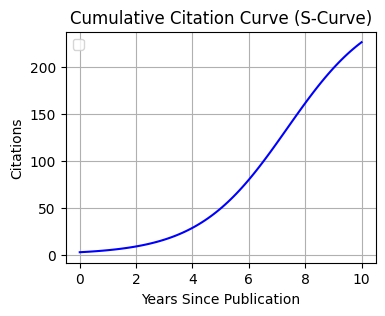

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data: (year, citation count for that year)
# Replace this with your actual citation data over time
years = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # e.g., years after publication
citations = np.array([1, 3, 7, 15, 30, 50, 80, 120, 160, 200])  # citation count for those years

# Logistic function definition (S-curve)
def logistic(t, L, k, t0):
    return L / (1 + np.exp(-k * (t - t0)))

# Initial guess for parameters: L, k, t0
initial_guess = [200, 0.5, 4]  # Example values for L, k, t0

# Fit the logistic curve to the data
params, covariance = curve_fit(logistic, years, citations, p0=initial_guess)

# Extract the fitted parameters
L, k, t0 = params

# Generate data for plotting the curve
t_values = np.linspace(0, 10, 100)  # Generate years for smooth curve
citation_curve = logistic(t_values, *params)

# Plotting the data and the fitted curve
plt.figure(figsize=(4, 3))
plt.plot(t_values, citation_curve, color='blue')
plt.title('Cumulative Citation Curve (S-Curve)')
plt.xlabel('Years Since Publication')
plt.ylabel('Citations')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import pandas as pd
import numpy as np

# Load the dataset
paper_csv = "Paper_Dataset_Bio.csv"
paper_dataset = pd.read_csv(paper_csv, encoding='utf-8-sig')

# Set decay rate (exponential decay)
lambda_decay = 0.2  # You can experiment with this value (between 0.1 and 0.2)

# Function to adjust citations based on the paper's age
def adjust_citations_by_age(citation_count, publication_year, current_year=2024, lambda_decay=0.2):
    # Calculate the age of the paper
    age = current_year - publication_year
    # Apply exponential decay to adjust citation count based on age
    decay_factor = np.exp(-lambda_decay * age)
    adjusted_citation = citation_count * decay_factor
    return adjusted_citation

# List to store adjusted citation values for regular and influential citations
adjusted_citations = []
adjusted_influential_citations = []

# Iterate through each paper and adjust citation based on its publication year
for index, row in paper_dataset.iterrows():
    publication_year = row['성과발생년도']
    
    # Citation counts for regular and influential citations
    citation_count = row['Citation_Count']  # Citation count for 2024
    influential_citation_count = row['Influential_Citation_Count']  # Influential citation count for 2024
    
    # Adjust citations based on age using exponential decay model
    adjusted_citation = adjust_citations_by_age(citation_count, publication_year)
    adjusted_influential_citation = adjust_citations_by_age(influential_citation_count, publication_year)
    
    # Append the adjusted values to the lists
    adjusted_citations.append(adjusted_citation)
    adjusted_influential_citations.append(adjusted_influential_citation)

# Add the new columns to the dataframe
paper_dataset['Citation_Weighted'] = adjusted_citations
paper_dataset['Inf_Citation_Weighted'] = adjusted_influential_citations

# Save the updated dataset
output_csv = "Paper_Dataset_With_Adjusted_Citations_Influential.csv"
paper_dataset.to_csv(output_csv, encoding='utf-8-sig', index=False)

print(f"Processed data has been saved to {output_csv}")


Processed data has been saved to Paper_Dataset_With_Adjusted_Citations_Influential.csv


In [34]:
import pandas as pd

# 데이터 로드
paper_csv = "Paper_Dataset_Bio.csv"
project_csv = "Project_Dataset_Bio.csv"

paper_dataset = pd.read_csv(paper_csv, encoding='utf-8-sig')
project_dataset = pd.read_csv(project_csv, encoding='utf-8-sig')

# '과제고유번호'별 평균 값 계산
avg_values = paper_dataset.groupby('과제고유번호').agg({
    'GDC_Paper': 'mean',
    'num_external_tie_paper': 'mean',
    'avg_num_external_tie_paper': 'mean',
    'Perf_Time': 'mean',
    'Authors_Count':'mean',
    'Central_1':'mean',
    'Central_5':'mean',
    'Central_10':'mean',
    'Citation_Weighted':'mean',
    'Inf_Citation_Weighted':'mean'
}).reset_index()

# 컬럼 이름 변경
avg_values.rename(columns={
    'GDC_Paper': 'GDC_Paper',
    'num_external_tie_paper': 'Num_External_Ties_Paper',
    'avg_num_external_tie_paper': 'Avg_Num_External_Ties_Paper',
    'Perf_Time':'Perf_Time_Paper',
    'Authors_Count':'Authors_Count_Paper',
    'Central_1':'Central_1_Paper',
    'Central_5':'Central_5_Paper',
    'Central_10':'Central_10_Paper',
    'Citation_Weighted':'Citation_Weighted_Paper',
    'Inf_Citation_Weighted':'Inf_Citation_Weighted_Paper'
}, inplace=True)

# Project_Dataset_Bio에 평균 값 병합
project_dataset = project_dataset.merge(avg_values, on='과제고유번호', how='left')

# 결과 저장
output_csv = "Project_Dataset_Bio_CV.csv"
project_dataset.to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f"Updated dataset saved to {output_csv}")


Updated dataset saved to Project_Dataset_Bio_CV.csv


#### CSV to DTA

In [1]:
import pandas as pd

# CSV 파일을 pandas DataFrame으로 읽어옵니다.
csv_file = "Project_Dataset_Bio.csv"
df = pd.read_csv(csv_file, encoding='utf-8')

column_mapping = {
    '사업ID': 'orgID',
    '사업ID_re': 'ID',
    '부처명': 'Department_Name',
    '공동위탁여부' : 'Joint_or_Contract',
    '총연구비': 'Total_Research_Funding',
    '정부연구비': 'Gov_Research_Funding',
    '총연구기간_시작': 'Research_Period_Start',
    '총연구기간_종료': 'Research_Period_End',
    '연구기간': 'Research_Period',
    '참여인원_공동위탁': 'Num_Researchers',
    '과학기술표준분류': 'Industry_Science_Tech',
    '육T관련기술': 'Industry_6T',
    '연구개발단계': 'Research_Development_Stage',
    '경제사회목적': 'Economic_Social_Purpose',
    '과제고유번호': 'Project_ID',
    '과제수행년도': 'Project_Year',
    '협업_매트릭스': 'Collaboration_Matrix',
    '협업_type_new': 'Collaboration_Matrix_Type',
    '총_참여조직_수': 'Num_Organizations',
    '대기업_수': 'Num_Large_Firm',
    '중견_수': 'Num_Medium_Firm',
    '중소_수': 'Num_Small_Firm',
    '대학_수': 'Num_Univ',
    '연구기관_수': 'Num_RI',
    '기타_수': 'Num_Others',
    'blau_index': 'Blau_Index',
    '논문_개수': 'Num_Papers',
    'SCI_개수': 'Num_SCI_Papers',
    '비SCI개수': 'Num_Non_SCI_Papers',
    '특허_개수': 'Num_Patents',
    '출원_개수': 'Num_Applications',
    '등록_개수': 'Num_Registrations',
    '국내_특허_개수': 'Num_Domestic_Patents',
    '국내_출원_개수': 'Num_Domestic_Applications',
    '국내_등록_개수': 'Num_Domestic_Registrations',
    '해외_특허_개수': 'Num_Foreign_Patents',
    '해외_출원_개수': 'Num_Foreign_Applications',
    '해외_등록_개수': 'Num_Foreign_Registrations',
    '성과_개수': 'Num_Perf',
    '연도별_밀도': 'Density_by_Year',
    'HHI': 'HHI',
    'rv_HHI': 'HHI_Reverse',
    'GDC': 'GDC',
    'num_external_tie': 'Num_External_Ties',
    'avg_num_external_tie': 'Avg_Num_External_Ties',
    'Avg_Blau_Partner': 'Avg_Blau_Partner',
    '공동위탁여부': 'Joint_or_Contract',
    'Project_Phase': 'Project_Phase'
}

# 열 이름을 변경하고, 결과를 새로운 DataFrame에 저장
df.rename(columns=column_mapping, inplace=True)

# Step 1: Ensure all object columns are converted to strings
# Convert any object column to string, handling None or NaN
df = df.apply(lambda x: x.astype(str) if x.dtype == 'object' else x)

# Step 2: Replace NaN or None with empty string for string-like columns
df = df.apply(lambda x: x.fillna('') if x.dtype == 'object' else x)

# Step 3: DTA 파일로 내보내기
dta_file_path = 'Project_Dataset_Bio_rv.dta'

# Save the dataframe to a .dta file, with empty strings for missing values
df.to_stata(dta_file_path, version=118, write_index=False)


#### Moderating Graph

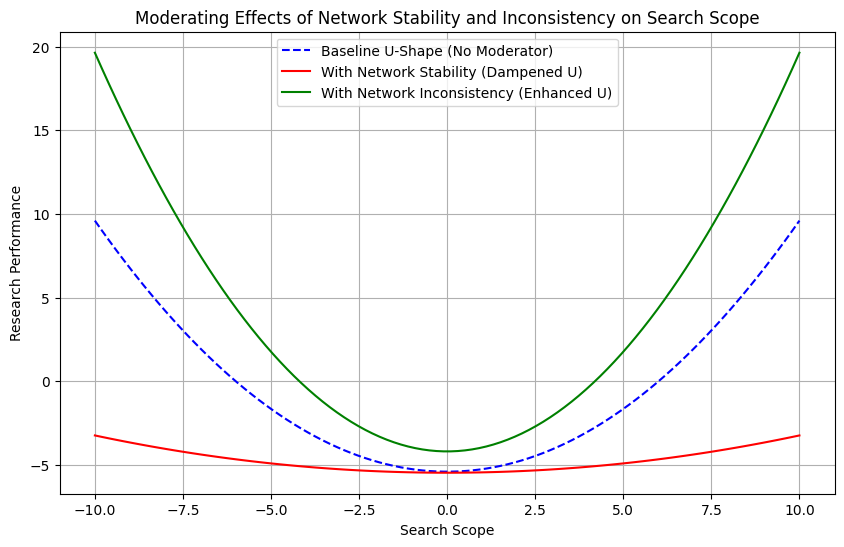

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of search scope values
search_scope = np.linspace(-10, 10, 100)  # Adjusted range to capture full U-shaped curve

# Baseline U-shaped relationship based on provided coefficients
# Baseline: b = 0.15 (positive U-shaped with a minimum), constant = -5.40
base_performance = 0.15 * search_scope**2 - 5.40

# Modifying the U-shape based on the interaction with network stability and inconsistency
# Network stability (dampened U): b = 0.15 - 0.127721, constant = -5.463879
performance_stability = (0.15 - 0.127721) * search_scope**2 - 5.463879

# Network inconsistency (enhanced U): b = 0.15 + 0.0882443, constant = -4.189842
performance_inconsistency = (0.15 + 0.0882443) * search_scope**2 - 4.189842

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(search_scope, base_performance, label="Baseline U-Shape (No Moderator)", color="blue", linestyle="--")
plt.plot(search_scope, performance_stability, label="With Network Stability (Dampened U)", color="red")
plt.plot(search_scope, performance_inconsistency, label="With Network Inconsistency (Enhanced U)", color="green")

# Labels and legend
plt.xlabel("Search Scope")
plt.ylabel("Research Performance")
plt.title("Moderating Effects of Network Stability and Inconsistency on Search Scope")
plt.legend()
plt.grid(True)
plt.show()


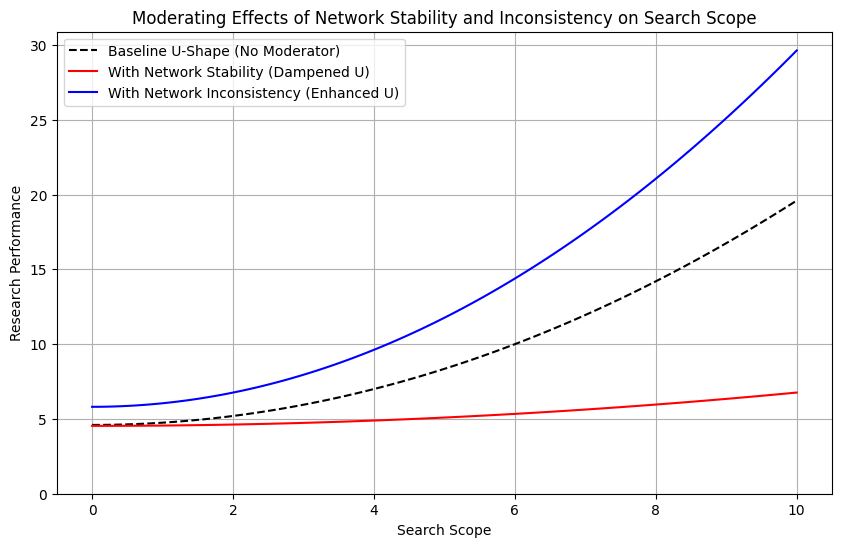

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of search scope values (positive)
search_scope = np.linspace(0, 10, 100)

# Baseline U-shaped relationship (Quadratic function for H1), shifted to keep values positive
# Adjust the baseline for performance to start above zero by adding a positive constant
baseline_performance = 0.15 * search_scope**2 - 5.40 + 10  # Adjust to make performance positive

# Modifying the U-shape based on the interaction with network stability and inconsistency
# Adding constants to keep values positive
performance_stability = (0.15 - 0.127721) * search_scope**2 - 5.463879 + 10  # Stability dampens the U-shape
performance_inconsistency = (0.15 + 0.0882443) * search_scope**2 - 4.189842 + 10  # Inconsistency enhances the U-shape

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(search_scope, baseline_performance, label="Baseline U-Shape (No Moderator)", color="black", linestyle="--")
plt.plot(search_scope, performance_stability, label="With Network Stability (Dampened U)", color="red")
plt.plot(search_scope, performance_inconsistency, label="With Network Inconsistency (Enhanced U)", color="blue")

# Labels and legend
plt.xlabel("Search Scope")
plt.ylabel("Research Performance")
plt.title("Moderating Effects of Network Stability and Inconsistency on Search Scope")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)  # Ensure research performance is always positive
plt.show()


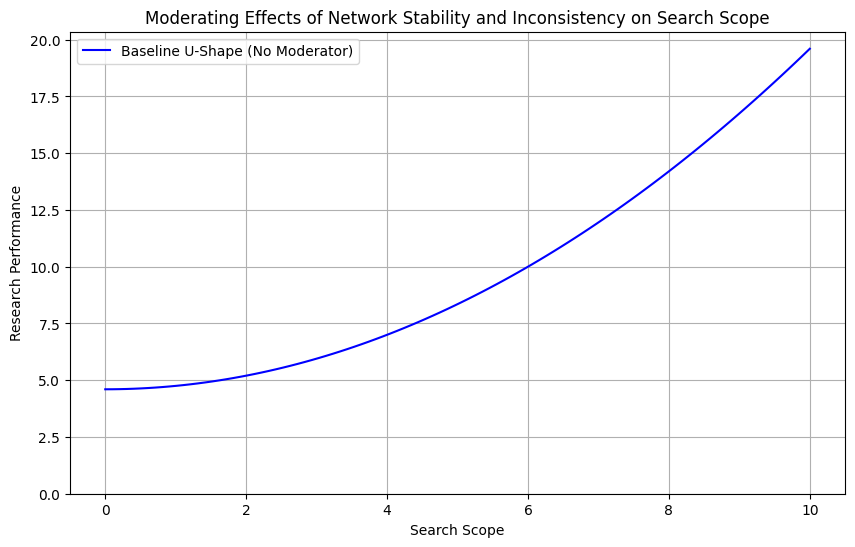

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of search scope values (positive)
search_scope = np.linspace(0, 10, 100)

# Baseline U-shaped relationship (Quadratic function for H1), shifted to keep values positive
# Adjust the baseline for performance to start above zero by adding a positive constant
baseline_performance = 0.15 * search_scope**2 - 5.40 + 10  # Adjust to make performance positive

# Modifying the U-shape based on the interaction with network stability and inconsistency
# Adding constants to keep values positive
performance_stability = (0.15 - 0.127721) * search_scope**2 - 5.463879 + 10  # Stability dampens the U-shape
performance_inconsistency = (0.15 + 0.0882443) * search_scope**2 - 4.189842 + 10  # Inconsistency enhances the U-shape

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(search_scope, baseline_performance, label="Baseline U-Shape (No Moderator)", color="blue", linestyle="-")


# Labels and legend
plt.xlabel("Search Scope")
plt.ylabel("Research Performance")
plt.title("Moderating Effects of Network Stability and Inconsistency on Search Scope")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)  # Ensure research performance is always positive
plt.show()


#### Exploration (Category Similarity)

In [ ]:
# import pandas as pd
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# # Load the dataset
# file_path = 'Paper_Dataset_Bio.csv'
# df = pd.read_csv(file_path, encoding='utf-8-sig')

# # Split topics in 'Scope_Top' column by ';'
# df['Scope_Top_Split'] = df['Scope_Top'].apply(lambda x: x.split(';'))

# # Remove projects with only one entry
# project_counts = df['과제고유번호'].value_counts()
# valid_projects = project_counts[project_counts > 1].index
# df_filtered = df[df['과제고유번호'].isin(valid_projects)]

# # Create a function to calculate Exploration (D) for each 과제고유번호
# def calculate_exploration(group):
#     # Get all unique topics across the group
#     unique_topics = sorted(set(topic for topics in group['Scope_Top_Split'] for topic in topics))
    
#     # Map each topic to an index
#     topic_index = {topic: i for i, topic in enumerate(unique_topics)}
    
#     # Generate vectors for each paper
#     vectors = []
#     for topics in group['Scope_Top_Split']:
#         vector = [0] * len(unique_topics)
#         for topic in topics:
#             vector[topic_index[topic]] += 1
#         vectors.append(np.array(vector) / len(topics))  # Normalize
    
#     # Calculate the average cosine similarity
#     if len(vectors) < 2:
#         return np.nan  # Cannot calculate for single entries
    
#     similarity_sum = 0
#     pair_count = 0
#     for i in range(len(vectors)):
#         for j in range(i + 1, len(vectors)):
#             similarity = cosine_similarity([vectors[i]], [vectors[j]])[0, 0]
#             similarity_sum += similarity
#             pair_count += 1
    
#     avg_similarity = similarity_sum / pair_count if pair_count > 0 else 0
#     exploration_d = 1 - avg_similarity
#     return exploration_d

# # Group by '과제고유번호' and calculate Exploration
# exploration_results = df_filtered.groupby('과제고유번호').apply(calculate_exploration).reset_index()
# exploration_results.columns = ['과제고유번호', 'Exploration_D']

# # Merge the results back with the original dataframe
# df_final = df_filtered.merge(exploration_results, on='과제고유번호', how='left')

# # Save the results to a new CSV file
# output_file = 'Exploration_Results.csv'
# df_final.to_csv(output_file, index=False, encoding='utf-8-sig')

# print(f"Exploration values saved to {output_file}")


C:\Users\river\AppData\Local\Temp\ipykernel_10640\1857733129.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exploration_results = df_filtered.groupby('과제고유번호').apply(calculate_exploration).reset_index()


Exploration values saved to Exploration_Results.csv


In [3]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the dataset
file_path = 'Paper_Dataset_Bio.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')

# Split topics in 'Scope_Top' column by ';'
df['Scope_Top_Split'] = df['Scope_Top'].apply(lambda x: x.split(';'))

# Calculate Exploration (D) for each 과제고유번호
def calculate_exploration(group):
    # Get all unique topics across the group
    unique_topics = sorted(set(topic for topics in group['Scope_Top_Split'] for topic in topics))
    
    # Map each topic to an index
    topic_index = {topic: i for i, topic in enumerate(unique_topics)}
    
    # Generate vectors for each paper
    vectors = []
    for topics in group['Scope_Top_Split']:
        vector = [0] * len(unique_topics)
        for topic in topics:
            vector[topic_index[topic]] += 1
        vectors.append(np.array(vector) / len(topics))  # Normalize
    
    # Calculate the average cosine similarity
    if len(vectors) < 2:
        return None  # Cannot calculate for single entries
    
    similarity_sum = 0
    pair_count = 0
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            similarity = cosine_similarity([vectors[i]], [vectors[j]])[0, 0]
            similarity_sum += similarity
            pair_count += 1
    
    avg_similarity = similarity_sum / pair_count if pair_count > 0 else 0
    exploration_d = 1 - avg_similarity
    return exploration_d

# Group by '과제고유번호' and calculate Exploration
exploration_results = df.groupby('과제고유번호').apply(calculate_exploration).reset_index()
exploration_results.columns = ['과제고유번호', 'Exploration_D']

# Merge the results back with the original dataframe
df_final = df.merge(exploration_results, on='과제고유번호', how='left')

# Save the results to a new CSV file
output_file = 'Exploration_Results.csv'
df_final.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Exploration values saved to {output_file}")


C:\Users\river\AppData\Local\Temp\ipykernel_10640\1962285181.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exploration_results = df.groupby('과제고유번호').apply(calculate_exploration).reset_index()


Exploration values saved to Exploration_Results.csv


#### Paper 기준 병합

In [4]:
import pandas as pd

# Load the datasets
paper_file = 'Paper_Dataset_Bio.csv'
project_file = 'Project_Dataset_Bio.csv'

# Read the datasets
paper_data = pd.read_csv(paper_file, encoding='utf-8-sig')
project_data = pd.read_csv(project_file, encoding='utf-8-sig')

# Merge the datasets on '과제고유번호'
merged_data = pd.merge(paper_data, project_data, on='과제고유번호', how='left')

# Save the merged dataset
output_file = 'Paper_Dataset_Bio_2.csv'
merged_data.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Merged dataset saved to {output_file}")


Merged dataset saved to Paper_Dataset_Bio_2.csv


#### Net inconsistency (Paper당)

In [6]:
import pandas as pd

# Load the project data
project_data = pd.read_csv("Paper_Dataset_Bio_2.csv")

# Function to check if formal organization is a substring of any combined organization
def are_orgs_equal(formal_org, combined_org):
    # Check if formal_org is a substring of combined_org or vice versa
    return formal_org in combined_org or combined_org in formal_org

# Function to calculate network inconsistency
def calculate_inconsistency(formal_orgs, combined_orgs):
    formal_set = set(formal_orgs.split(', '))  # Formal organizations (Project_Net)
    combined_set = set(combined_orgs.split(', '))  # Combined organizations (unique_org)

    unmatched_count = 0

    # Check each combined organization if it matches any formal organization
    for combined in combined_set:
        match_found = False
        for formal in formal_set:
            # If the organization is a substring of another, treat it as a match
            if are_orgs_equal(formal, combined):
                match_found = True
                break
        if not match_found:
            unmatched_count += 1

    # Calculate inconsistency as the proportion of unmatched organizations in 'unique_org'
    inconsistency = unmatched_count / len(combined_set) if combined_set else 0
    return inconsistency

# Apply the inconsistency calculation to the dataframe
project_data['Net_Incon_Paper'] = project_data.apply(
    lambda row: calculate_inconsistency(row['Project_Net'], row['Paper_Org_KR']) 
    if isinstance(row['Paper_Org_KR'], str) and row['Paper_Org_KR'] else None, axis=1
)

# Save the updated project data to a new CSV file
project_data.to_csv("Paper_Dataset_Bio_2_Incon.csv", index=False, encoding='utf-8-sig')

# Display a preview to verify changes
project_data.head()


,ID_B,ID_B_Org,ID_Project_Unique,ID_Paper,Year,Year_Perf,Department,SCI_YN,Title,Journal,...,Num_Foreign_Applications,Num_Foreign_Registrations,Num_Perf,Joint_or_Contract,Project_Phase,Citation_Count,Citation_Weighted,Influential_Citation_Count,Inf_Citation_Weighted,Net_Incon_Paper
0,124,1.81E+22,1315000802,39,2016,2016,26,1.0,Population genetic study of 10 short tandem re...,JOURNAL OF VETERINARY SCIENCE,...,2,0,6,2,2,6,1.211379,1.0,0.201897,0.5
1,125,1.81E+22,1315001076,72,2018,2018,26,1.0,Enhanced sensitivity of CpG island search and ...,FORENSIC SCIENCE INTERNATIONAL-GENETICS,...,2,0,10,2,1,2,0.602388,0.0,0.000000,0.5
2,125,1.81E+22,1315001076,75,2018,2018,26,1.0,A Simple Method of VNTR D1S80 Locus Allelic La...,JOURNAL OF FORENSIC SCIENCES,...,2,0,10,2,1,3,0.903583,0.0,0.000000,0.0
3,125,1.81E+22,1315001076,76,2018,2018,26,1.0,Simple and rapid identification of saliva by d...,FORENSIC SCIENCE INTERNATIONAL-GENETICS,...,2,0,10,2,1,17,5.120302,0.0,0.000000,0.0
4,125,1.81E+22,1315001076,74,2018,2018,26,1.0,A validation study of DNA methylation-based ag...,LEGAL MEDICINE,...,2,0,10,2,1,27,8.132244,3.0,0.903583,0.5


In [9]:
import pandas as pd

# CSV 파일을 pandas DataFrame으로 읽어옵니다.
csv_file = "Paper_Dataset_Bio.csv"
df = pd.read_csv(csv_file, encoding='utf-8-sig')

# Step 1: Ensure all object columns are converted to strings
# Convert any object column to string, handling None or NaN
df = df.apply(lambda x: x.astype(str) if x.dtype == 'object' else x)

# Step 2: Replace NaN or None with empty string for string-like columns
df = df.apply(lambda x: x.fillna('') if x.dtype == 'object' else x)

# Step 3: DTA 파일로 내보내기
dta_file_path = 'Paper_Dataset_Bio.dta'

# Save the dataframe to a .dta file, with empty strings for missing values
df.to_stata(dta_file_path, version=118, write_index=False)


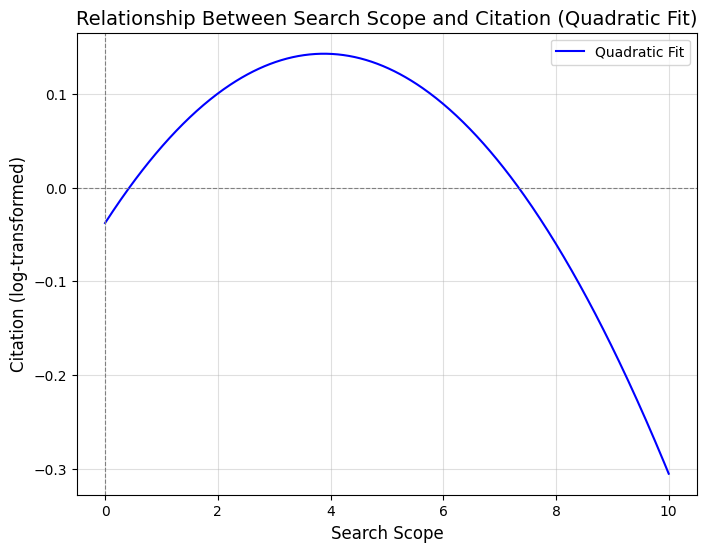

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Coefficients from regression output
coef_linear = 0.092933   # Coefficient for Search_Scope
coef_quadratic = -0.0119652  # Coefficient for Search_Scope_2
intercept = -0.0378286   # Intercept

# Generate values for Search_Scope (x-axis)
search_scope = np.linspace(0, 10, 500)  # Assume a reasonable range for search scope

# Calculate predicted Citation (y-axis) using the quadratic equation
citation = intercept + coef_linear * search_scope + coef_quadratic * search_scope**2

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(search_scope, citation, label="Quadratic Fit", color="blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add y=0 line for reference
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add x=0 line for reference
plt.title("Relationship Between Search Scope and Citation (Quadratic Fit)", fontsize=14)
plt.xlabel("Search Scope", fontsize=12)
plt.ylabel("Citation (log-transformed)", fontsize=12)
plt.grid(alpha=0.4)
plt.legend()
plt.show()


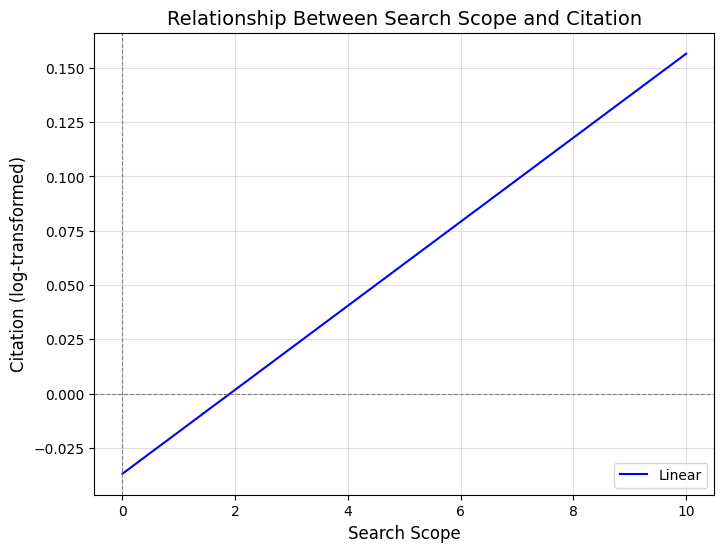

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Coefficients from regression output
coef_linear = 0.019339   # Coefficient for Search_Scope
intercept = -0.0368716   # Intercept

# Generate values for Search_Scope (x-axis)
search_scope = np.linspace(0, 10, 500)  # Assume a reasonable range for search scope

# Calculate predicted Citation (y-axis) using the quadratic equation
citation = intercept + coef_linear * search_scope

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(search_scope, citation, label="Linear", color="blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add y=0 line for reference
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add x=0 line for reference
plt.title("Relationship Between Search Scope and Citation", fontsize=14)
plt.xlabel("Search Scope", fontsize=12)
plt.ylabel("Citation (log-transformed)", fontsize=12)
plt.grid(alpha=0.4)
plt.legend()
plt.show()


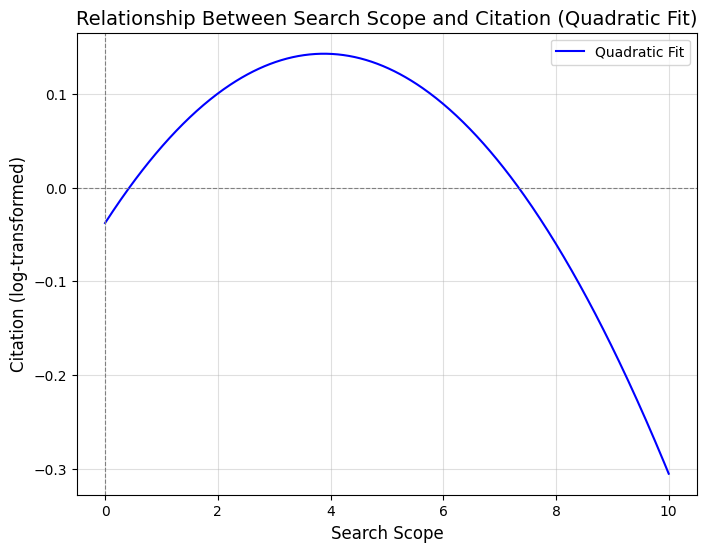

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Coefficients from regression output
coef_linear = 0.092933   # Coefficient for Search_Scope
coef_quadratic = -0.0119652  # Coefficient for Search_Scope_2
intercept = -0.0378286   # Intercept

# Generate values for Search_Scope (x-axis)
search_scope = np.linspace(0, 10, 500)  # Assume a reasonable range for search scope

# Calculate predicted Citation (y-axis) using the quadratic equation
citation = intercept + coef_linear * search_scope + coef_quadratic * search_scope**2

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(search_scope, citation, label="Quadratic Fit", color="blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add y=0 line for reference
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)  # Add x=0 line for reference
plt.title("Relationship Between Search Scope and Citation (Quadratic Fit)", fontsize=14)
plt.xlabel("Search Scope", fontsize=12)
plt.ylabel("Citation (log-transformed)", fontsize=12)
plt.grid(alpha=0.4)
plt.legend()
plt.show()


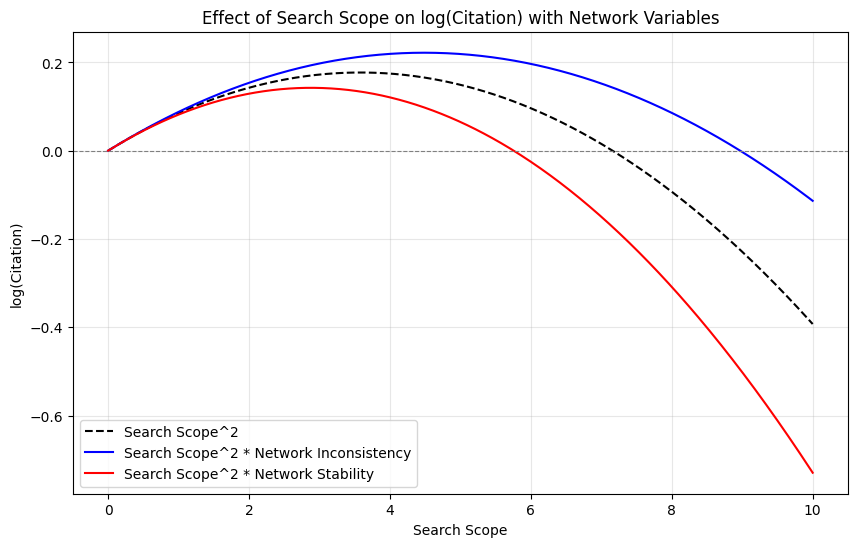

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x-axis values for Search Scope
search_scope = np.linspace(0, 10, 500)  # Generate values between 0 and 10

# Coefficients for the quadratic function (only quadratic term)
coef_quad = -0.0138235
coef_linear = 0.0989667

# Coefficients for the quadratic function with moderator
coef_quad_moderator = -0.0220994
coef_linear_moderator = 0.0989667  # Assuming unchanged linear term
coef_quad_stability = -0.0118624
coef_linear_stability = 0.0989667 
interaction_effect = 0.0110674  # Interaction term with moderator
net_incon_unique = 1  # Example moderator level
interaction_effect_stability = -0.0053297  # Interaction term with stability
net_stability_org = 1  # Example stability moderator level

# Calculate y-axis values for both cases
y_quad = coef_linear * search_scope + coef_quad * search_scope**2
y_quad_moderator = (coef_linear_moderator * search_scope +
                    coef_quad_moderator * search_scope**2 +
                    interaction_effect * search_scope**2 * net_incon_unique)
y_quad_stability = (coef_linear_stability * search_scope +
                    coef_quad_stability * search_scope**2 +
                    interaction_effect_stability * search_scope**2 * net_stability_org)


# Plotting
plt.figure(figsize=(10, 6))

# Plot only quadratic term
plt.plot(search_scope, y_quad, label="Search Scope^2", color="black", linestyle="--")

# Plot quadratic term with Network Inconsistency moderator
plt.plot(search_scope, y_quad_moderator, label="Search Scope^2 * Network Inconsistency", color="blue")

# Plot quadratic term with Network Stability moderator
plt.plot(search_scope, y_quad_stability, label="Search Scope^2 * Network Stability", color="red")

# Add titles and labels
plt.title("Effect of Search Scope on log(Citation) with Network Variables")
plt.xlabel("Search Scope")
plt.ylabel("log(Citation)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line at y=0
plt.legend()
plt.grid(alpha=0.3)

# Display the plot
plt.show()

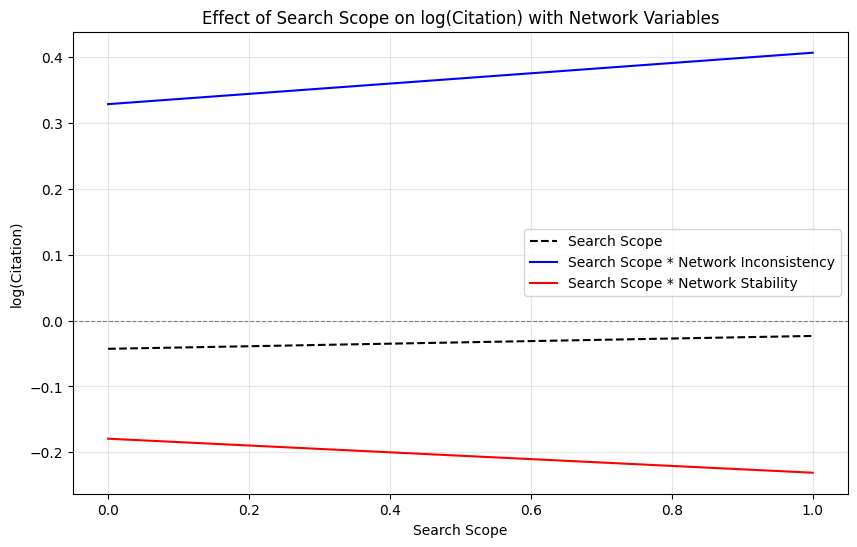

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of 'Search Scope' for plotting
search_scope = np.linspace(0, 1, 100)  # Adjust range (0 to 1) as needed

# Define coefficients
search_scope_coeff = 0.0195265
constant_black = -0.0428862
interaction_stability_coeff = -0.0516214
constant_red = -0.179282
interaction_inconsistency_coeff = 0.0780262
constant_blue = 0.3283724

# Calculate y values for each scenario
y_quad = search_scope_coeff * search_scope + constant_black  # Black (Search Scope only)
y_quad_stability = (
    search_scope_coeff * search_scope +
    interaction_stability_coeff * search_scope +
    constant_red
)  # Red (Search Scope with Network Stability)
y_quad_inconsistency = (
    search_scope_coeff * search_scope +
    interaction_inconsistency_coeff * search_scope +
    constant_blue
)  # Blue (Search Scope with Network Inconsistency)

# Plotting
plt.figure(figsize=(10, 6))

# Plot quadratic term only
plt.plot(search_scope, y_quad, label="Search Scope", color="black", linestyle="--")

# Plot quadratic term with Network Inconsistency moderator
plt.plot(search_scope, y_quad_inconsistency, label="Search Scope * Network Inconsistency", color="blue")

# Plot quadratic term with Network Stability moderator
plt.plot(search_scope, y_quad_stability, label="Search Scope * Network Stability", color="red")

# Add titles and labels
plt.title("Effect of Search Scope on log(Citation) with Network Variables")
plt.xlabel("Search Scope")
plt.ylabel("log(Citation)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line at y=0
plt.legend()
plt.grid(alpha=0.3)

# Show plot
plt.show()
